In [1]:
! pip install gymnasium[classic_control]
! pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 45.8 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from typing import Callable
import matplotlib.patches as mpatches
from IPython import display


def test_agent(env: gym.Env, policy: Callable, episodes: int = 10) -> None:
    plt.figure(figsize=(8, 8))
    for episode in range(episodes):
        state = env.reset()
        done = False
        img = plt.imshow(env.render(mode='rgb_array'))
        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, _, done, _ = env.step(action)
            img.set_data(env.render(mode='rgb_array'))
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            state = next_state

def seed_everything(env: gym.Env, seed: int = 42) -> None:
    """
    Seeds all the sources of randomness so that experiments are reproducible.
    Args:
        env: the environment to be seeded.
        seed: an integer seed.
    Returns:
        None.
    """
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch._set_deterministic(True)


def plot_cost_to_go(env, q_network, xlabel=None, ylabel=None):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)

    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = - q_network(q_net_input).max(dim=-1, keepdim=True)[0]
    Z = Z.reshape(100, 100).detach().numpy()
    X = X.numpy()
    Y = Y.numpy()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylabel(ylabel, size=14)
    ax.set_title("Estimated cost-to-go", size=18)
    plt.tight_layout()
    plt.show()


def plot_max_q(env, q_network, xlabel=None, ylabel=None, action_labels=[]):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)
    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = q_network(q_net_input).argmax(dim=-1, keepdim=True)
    Z = Z.reshape(100, 100).T.detach().numpy()
    values = np.unique(Z.ravel())
    values.sort()

    plt.figure(figsize=(5, 5))
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.title("Optimal action", size=18)

    # im = plt.imshow(Z, interpolation='none', cmap='jet')
    im = plt.imshow(Z, cmap='jet')
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, action_labels)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), np.array(vals))
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), np.array(vals).detach().numpy())
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


In [3]:
# Create the environment
env = gym.make('MountainCar-v0')
seed_everything(env)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [4]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"MountainCar env: State dimensions: {state_dims}, Number of actions: {num_actions}")

MountainCar env: State dimensions: 2, Number of actions: 3


In [5]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [6]:
env = PreprocessEnv(env)

In [7]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[-0.4452,  0.0000]])
Next state: tensor([[-0.4468, -0.0016]]), Reward: tensor([[-1.]]), Done: tensor([[False]])


In [8]:
q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions))

In [9]:
target_q_network = copy.deepcopy(q_network).eval()

In [10]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

In [11]:
class ReplayMemory:

    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

In [12]:
def deep_sarsa(q_network, policy, episodes, alpha=0.001, batch_size=32, gamma=0.99, epsilon=0.):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)                
                qsa_b = q_network(state_b).gather(1, action_b)
                next_action_b = policy(next_state_b)
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b)
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()
                
                loss.item()
                stats['MSE Loss'].append(loss.detach().numpy())
            
            state = next_state
            ep_return += reward.item()
        
        stats['Returns'].append(ep_return)
        
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())
        
    return stats


In [13]:
stats = deep_sarsa(q_network, policy, 1000, alpha=0.01, epsilon=0.0)

100%|██████████| 1000/1000 [10:13<00:00,  1.63it/s]


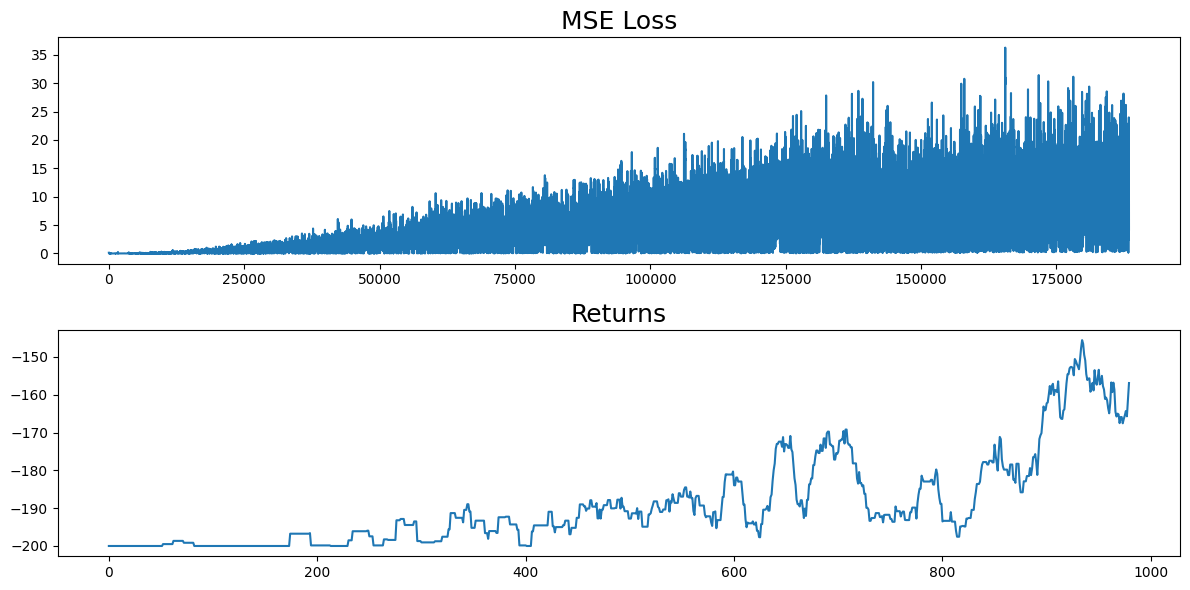

In [14]:
plot_stats(stats)

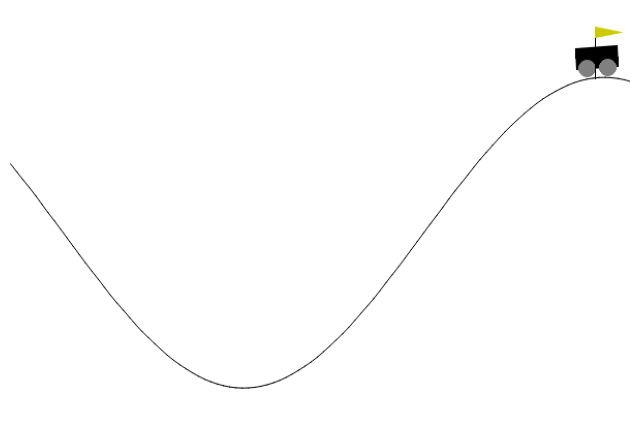

In [17]:
%matplotlib inline
test_agent(env, policy, episodes=2)